In [1]:
import torch, timm
from torchvision.transforms import transforms
from softdataset import TripletImageDataset, data_split
from original_dataset import OriginalImageDataset, data_split, OriginalDataset
from torchvision.transforms import ToTensor, Resize
from torch.utils.data import DataLoader
from torchvision import transforms
import glob, os, random, json
from dataset import TripleDataset
from torch.nn import *
from collections import OrderedDict as OD
from tqdm import tqdm
import numpy as np
from PIL import Image
from sketch_dataset import SketchyImageDataset
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import cv2

/home/ubuntu/anaconda3/envs/retrieval/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Inference with SketchyDatabase

In [2]:
def get_fm(fm):
        pool = AvgPool2d((fm.shape[2],fm.shape[3]))
        return torch.reshape(pool(fm), (-1, fm.shape[1]))

def get_dl(path, bs, random = True, trainval_json="", trainval="test"):        
    
    ''' 
    Get path to the images and returns dataloader with transformations applied
    Arguments:

    path - path to the dir with images;
    bs - batch_size;
    random - if False loads train test split json file else randomly mix dataset.      

    '''
    
    transformations = {}   

    transformations['qry'] = transforms.Compose([
                            transforms.Resize((224,224)),
                            # transforms.RandomHorizontalFlip(),
                            # transforms.RandomRotation(90, fill = fill),
                            # transforms.ColorJitter([0.3, 1]),
                            # transforms.GaussianBlur(9, (0.5, 3.0)),
                            transforms.ToTensor(),
                                                  ])

    transformations['pos'] = transforms.Compose([
        transforms.Resize((224,224)),
        # transforms.RandomRotation(90, fill = fill_sketch),
        # transforms.RandomPerspective(distortion_scale = distortion_scale, p = p, fill = fill_sketch),
        transforms.ToTensor(),
    ])  
    transformations['neg'] = transforms.Compose([
        transforms.Resize((224,224)),
        # transforms.RandomRotation(90, fill = fill_sketch),
        # transforms.RandomPerspective(distortion_scale = distortion_scale, p = p, fill = fill_sketch),
        transforms.ToTensor(),
    ])
    
    out_path = "data/sketchy_database_256_soft_split_cat.json"
    # out_path = data_split(path, out_path)

    # tr_ds = SketchyImageDataset(data_dir = path, transform_dic=transformations, random=True, trainval_json=out_path, trainval='train', load_images=False)
    # val_ds = SketchyImageDataset(data_dir = path, transform_dic=transformations, random=True, trainval_json=out_path, trainval='val', load_images=False)
    dataset = SketchyImageDataset(data_dir = path, transform_dic=transformations, random=True, trainval_json=out_path, trainval='test', load_images=False)
    
    transformations = {}   

    transformations['qry'] = transforms.Compose([transforms.ToTensor()])
    transformations['pos'] = transforms.Compose([transforms.ToTensor()])
    transformations['neg'] = transforms.Compose([transforms.ToTensor()])
    
    # dataset = OriginalImageDataset(data_dir = path, transform_dic=transformations, random=True, load_images=False)
    num_classes = dataset.get_cat_length()
    print(f"The dataset has {num_classes} classes")    
    print(f"Number of test samples: {len(dataset)}")
    
    test_dl = DataLoader(dataset, batch_size=bs, shuffle=True, drop_last=True, num_workers=8)

    return num_classes, dataset, test_dl


def load_checkpoint(checkpoint_path, model_name, pretrained=False, num_classes=None, from_pytorch_lightning=True, init_conv=False):

        ''' 
        
        Loads checkpoint_path from the given path to the directory with the trained model.
        Arguments:
        
        checkpoint_path - path to the dir with the trained model;
        model_name - name of the trained model (name is the same as in the timm library);
        pretrained - creates a model with pretrained weights on ImageNet;
        init_conv - initial convolution layer, default is True;
        from_pytorch_lightning - used to load the trained model from pytorch_lightning.
        If True the model is trained using pytorch_lightning, else with a regular torch library;
        Default is False
        
        '''        
        assert num_classes is not None, "Please set the number of classes in the dataset!"
        
        if from_pytorch_lightning: # for a pytorch_lightning model
            checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
            # print(checkpoint['state_dict'].keys())
            if init_conv:                
                base_model = timm.create_model(model_name, pretrained=True, num_classes=num_classes)
                conv_layer = torch.nn.Sequential(torch.nn.Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1),padding=(1,1), bias=False), 
                 # nn.Conv2d(3, 3, kernel_size=(3, 3), stride=(2, 2),padding=(1,1), bias=False), 
                 # nn.MaxPool2d(kernel_size=(3,3), stride=(2,2), padding=(1,1)),
                 torch.nn.SiLU(inplace=True))
                model = torch.nn.Sequential(conv_layer, base_model) 
                print("Model with init_conv True")
            else:
                model = timm.create_model(model_name, num_classes=num_classes)
                # model.head.fc = Identity()
                print("Model with init_conv False")

            # create new OrderedDict that does not contain `model.` (for the checkpoint from the pytorch_lightning)
            new_state_dict = OD()
            for k, v in checkpoint['state_dict'].items():
                name = k.replace("model.", "") # remove `model.`
                new_state_dict[name] = v
            # load params
            model.load_state_dict(new_state_dict, strict=True)
            print(f"Model {model_name} trained using pytorch lightning checkpoint is successfully loaded!")

        else: # for a regular torch model  
            if pretrained:
                model = timm.create_model(model_name, num_classes=num_classes)
                print(f"Model {model_name} with pretrained weights is successfully loaded!")
            else:
                model = timm.create_model("rexnet_150", num_classes=num_classes)
                state_dict = torch.load(checkpoint_path, map_location=device)
                model.load_state_dict(state_dict)
                # num_features = model.head.fc.in_features
                # model.classifier = Linear(num_features, num_classes) if num_classes > 0 else Identity() 
                print(f"Model {model_name} with the best weights is successfully loaded!")            

        return model
    
def inference(model, dataloader, device):

        ''' 
        
        Inference using trained model and test dataloader.
        Arguments:
        
        model - trained model from the checkpoint (see load_checkpoint function);
        dataloader - test dataloader (see get_dl function);
        device - gpu device.
        
        '''   
        
        ims, poss, negs, pos_scores, neg_scores, fms_ims_all, top_vals, scores, fms_poss_all, fms_negs_all,  classes_all, top_inds, top_r_list, pred_lbls_all = [], [], [], [], [], [], [], [], [], [], [], [], [], []
        cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
        model.to(device)
        model.eval()
        model.head = Identity()
        
        print("Obtaining embeddings...")        
        for i, batch_all in tqdm(enumerate(dataloader)):
            # if i == 1:
            #     break
            ims_all, poss_all, negs_all, clss_all, regs_all = batch_all['qry'], batch_all['pos'][0], batch_all['neg'][0], batch_all['cat_idx'], batch_all['prod_idx']
            ims.extend(ims_all)
            poss.extend(poss_all)
            negs.extend(negs_all)
            classes_all.extend(clss_all.to(device)) 
            
            with torch.no_grad():
                
                # with torch.cuda.amp.autocast():
                fm_ims_all = model.forward_features(ims_all.to(device))            
                # lbl_ims_all = model.head(fm_ims_all)
                fm_poss_all = model.forward_features(poss_all.to(device))
                # lbl_poss_all = model.head(fm_poss_all)
                fm_negs_all = model.forward_features(negs_all.to(device))
                # lbl_negs_all = model.head(fm_negs_all)
                fm_ims_all = get_fm(fm_ims_all)
                fm_poss_all = get_fm(fm_poss_all)
                fm_negs_all = get_fm(fm_negs_all)
                fms_ims_all.extend(fm_ims_all) #bs, fm 
                fms_poss_all.extend(fm_poss_all)
                fms_negs_all.extend(fm_negs_all)

        print("Embeddings are obtained!")        
        print("Calculating metrics...")
        top1 = 0 
        top3 = 0
        fms_ims_all = torch.stack(fms_ims_all) 
        fms_poss_all = torch.stack(fms_poss_all)
        fms_negs_all = torch.stack(fms_negs_all)        
        ims = torch.stack(ims)
        poss = torch.stack(poss)        
        negs = torch.stack(negs)        
        classes_all = torch.stack(classes_all)
        
        
        for idx, (gt_reg, fm) in enumerate(zip(classes_all, fms_ims_all)):
            pos_score = cos(fm.unsqueeze(0), fms_poss_all[idx].unsqueeze(0)) #(len(dl))
            pos_scores.append(pos_score.item())
            neg_score = cos(fm.unsqueeze(0), fms_negs_all[idx].unsqueeze(0)) #(len(dl))
            neg_scores.append(neg_score.item())
            # print(f"\nCosine similarity of a qry image with the corresponding pos sketch image: {pos_score.item():.3f}")
            # print(f"Cosine similarity of a qry image with the corresponding neg sketch image: {neg_score.item():.3f}")
            vals, inds = torch.topk(cos(fm, fms_poss_all), k=150)
            
            classes = [int(classes_all[int(ind)]) for ind in inds]
            top_i, top_v, top_r, top_c = [], [], [], []
            
            for num, (i, v, r) in enumerate(zip(inds, vals, classes)):
                if r not in top_r:
                    top_r.append(r)
                    top_v.append(v)
                    top_i.append(int(i))
                if len(top_r) == 3:
                    break
            top3 += 1 if int(gt_reg) in top_r else 0
            top1 += 1 if int(gt_reg) == top_r[0] else 0
            
            top_inds.append(top_i)
            top_vals.append(top_v)
            top_r_list.append(top_r)        
            
        return OD([('top1', top1/len(fms_ims_all)), ('top3', top3/len(fms_ims_all)), ('scores', torch.mean(torch.FloatTensor(pos_scores))),
                    ('fms_ims_all', fms_ims_all), ('classes_all', classes_all), ('fms_poss_all', fms_poss_all),
                    ('ims', ims), ('poss', poss), ('negs', negs), ('fms_negs_all', fms_negs_all),
                    ('topk_inds_reg', top_r_list), ('topk_inds', top_inds), ('top_vals', top_vals), ('top_r_list', top_r_list)])

In [3]:
path = "/home/ubuntu/workspace/dataset/sketchy_database_256"
bs=32
device='cuda:1'
num_classes, test_ds, test_dl = get_dl(path=path, bs=bs)
idx_to_clss = {v:k for k,v in test_ds.cat_idx.items()}
checkpoint_path = "epoch=37-val_loss=0.26-cos_sims=0.95.ckpt"
m = load_checkpoint(checkpoint_path, num_classes=num_classes, from_pytorch_lightning=True, model_name='efficientnet_b3a')
results = inference(m, test_dl, device)
results['top3'], results['top1'], results['scores']

The dataset has 125 classes
Number of test samples: 8736
Model with init_conv False
Model efficientnet_b3a trained using pytorch lightning checkpoint is successfully loaded!
Obtaining embeddings...


273it [00:26, 10.15it/s]


Embeddings are obtained!
Calculating metrics...


(0.9789377289377289, 0.9634844322344323, tensor(0.9554))


	Input Image
	Class: raccoon


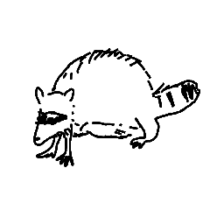


	Positive Image
	Class: raccoon


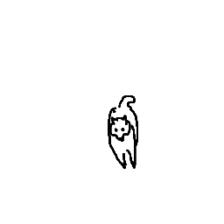


					Predicted Images
					   Grad CAM



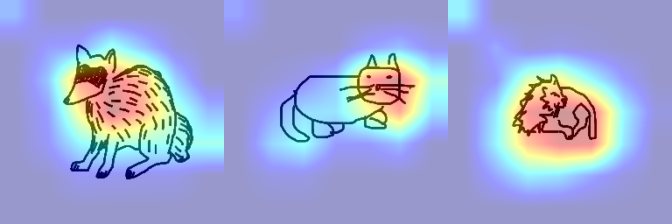

	cos_sim:0.986 			cos_sim:0.934 			cos_sim:0.921
	pred_class: raccoon 		pred_class: cat 		pred_class: lion


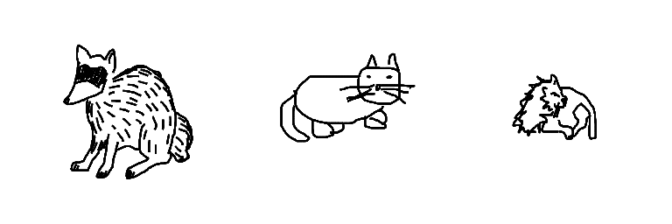


	Input Image
	Class: pretzel


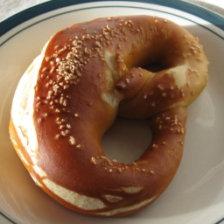


	Positive Image
	Class: pretzel


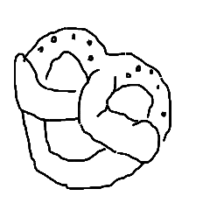


					Predicted Images
					   Grad CAM



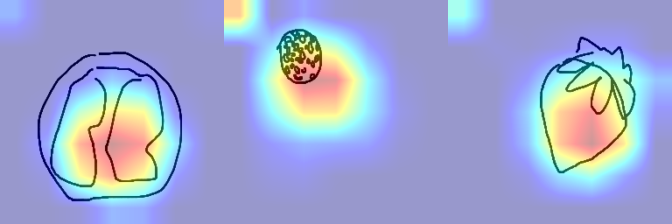

	cos_sim:0.893 			cos_sim:0.752 			cos_sim:0.725
	pred_class: pretzel 		pred_class: pizza 		pred_class: strawberry


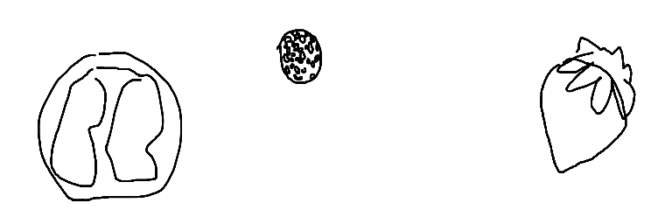


	Input Image
	Class: shark


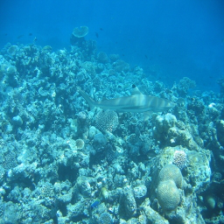


	Positive Image
	Class: shark


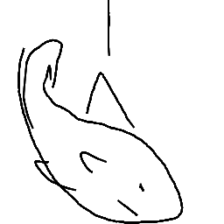


					Predicted Images
					   Grad CAM



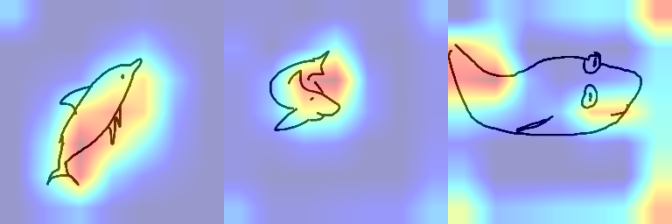

	cos_sim:0.904 			cos_sim:0.902 			cos_sim:0.837
	pred_class: dolphin 		pred_class: shark 		pred_class: fish


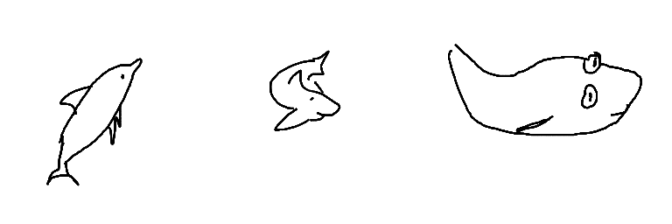


	Input Image
	Class: lizard


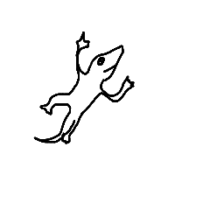


	Positive Image
	Class: lizard


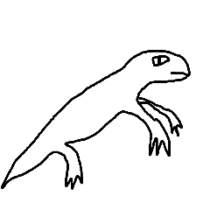


					Predicted Images
					   Grad CAM



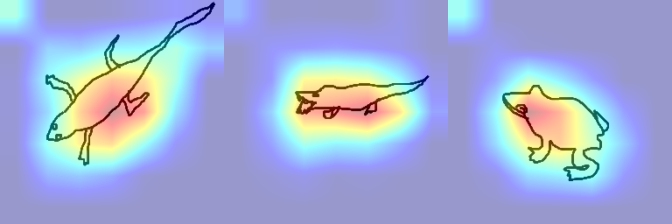

	cos_sim:0.992 			cos_sim:0.977 			cos_sim:0.831
	pred_class: lizard 		pred_class: crocodilian 		pred_class: frog


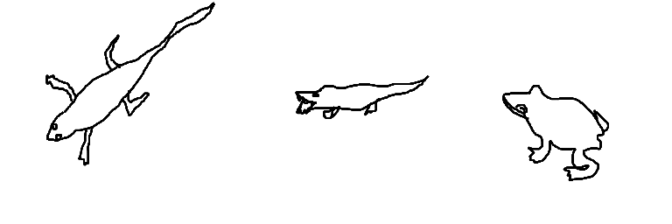


	Input Image
	Class: armor


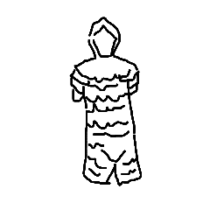


	Positive Image
	Class: armor


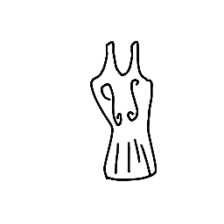


					Predicted Images
					   Grad CAM



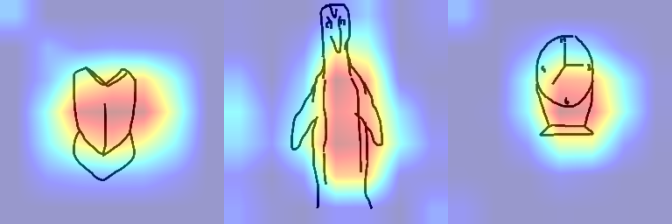

	cos_sim:0.996 			cos_sim:0.614 			cos_sim:0.575
	pred_class: armor 		pred_class: penguin 		pred_class: alarm_clock


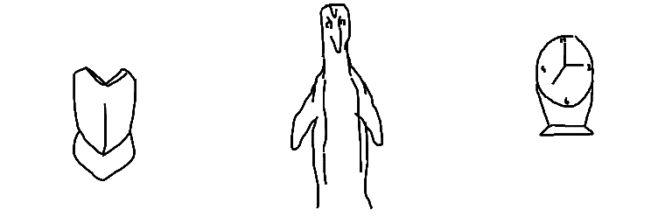


	Input Image
	Class: trumpet


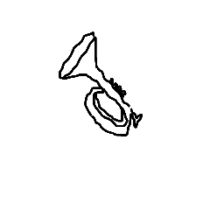


	Positive Image
	Class: trumpet


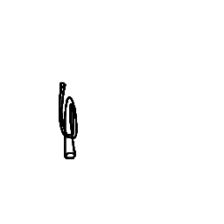


					Predicted Images
					   Grad CAM



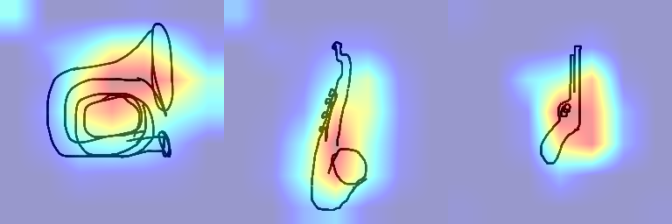

	cos_sim:0.994 			cos_sim:0.920 			cos_sim:0.604
	pred_class: trumpet 		pred_class: saxophone 		pred_class: pistol


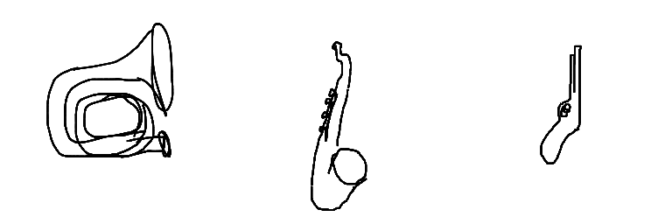


	Input Image
	Class: sailboat


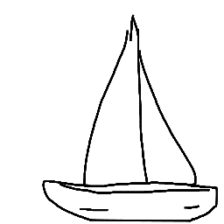


	Positive Image
	Class: sailboat


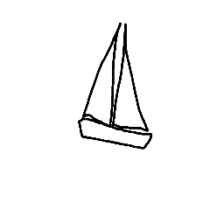


					Predicted Images
					   Grad CAM



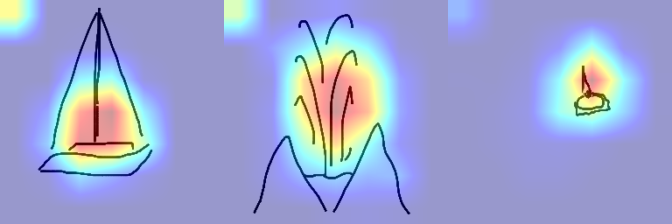

	cos_sim:0.995 			cos_sim:0.629 			cos_sim:0.625
	pred_class: sailboat 		pred_class: geyser 		pred_class: candle


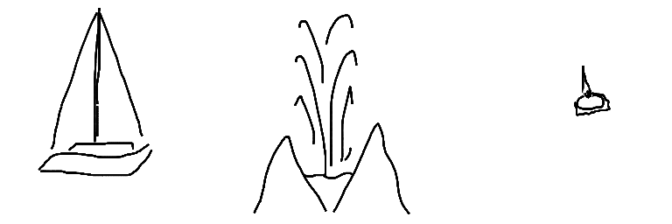


	Input Image
	Class: wading_bird


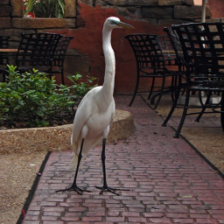


	Positive Image
	Class: wading_bird


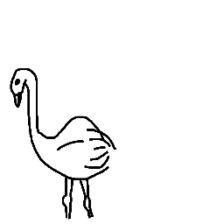


					Predicted Images
					   Grad CAM



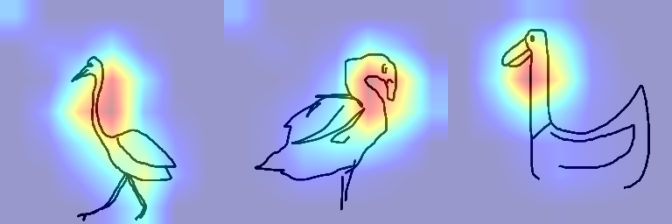

	cos_sim:0.973 			cos_sim:0.955 			cos_sim:0.925
	pred_class: wading_bird 		pred_class: swan 		pred_class: duck


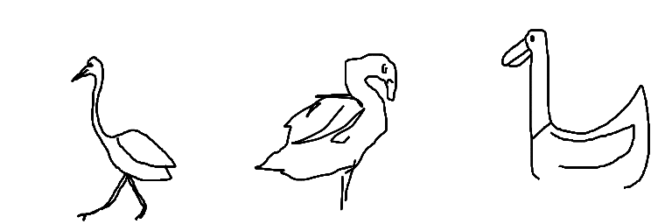


	Input Image
	Class: jack-o-lantern


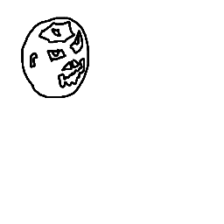


	Positive Image
	Class: jack-o-lantern


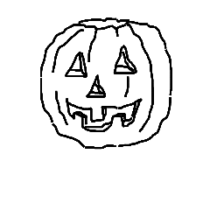


					Predicted Images
					   Grad CAM



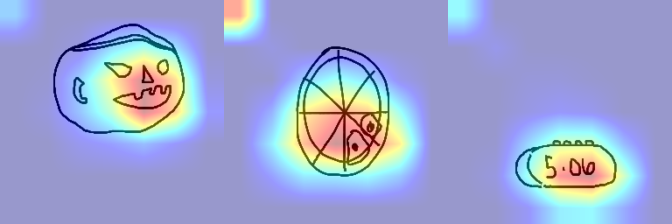

	cos_sim:0.979 			cos_sim:0.808 			cos_sim:0.721
	pred_class: jack-o-lantern 		pred_class: pizza 		pred_class: alarm_clock


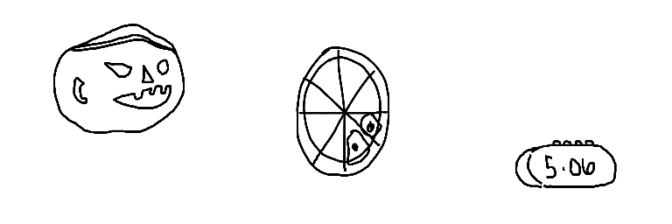


	Input Image
	Class: cat


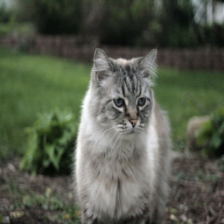


	Positive Image
	Class: cat


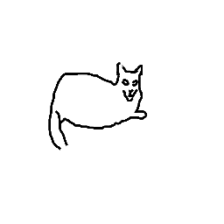


					Predicted Images
					   Grad CAM



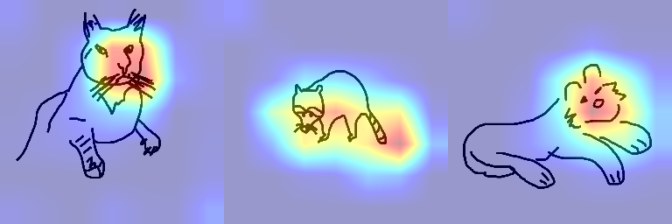

	cos_sim:0.987 			cos_sim:0.970 			cos_sim:0.937
	pred_class: cat 		pred_class: raccoon 		pred_class: tiger


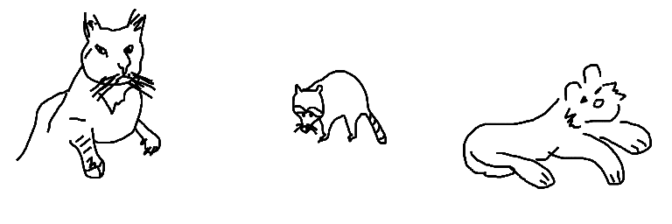


	Input Image
	Class: frog


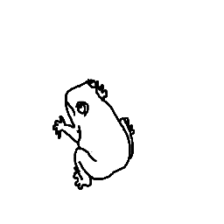


	Positive Image
	Class: frog


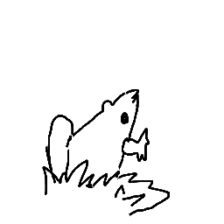


					Predicted Images
					   Grad CAM



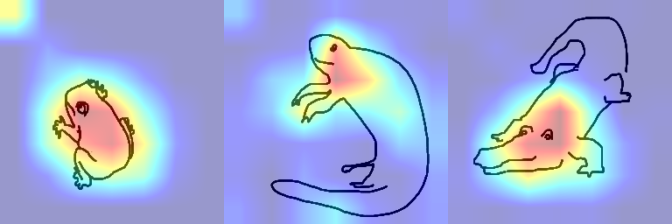

	cos_sim:1.000 			cos_sim:0.840 			cos_sim:0.772
	pred_class: frog 		pred_class: lizard 		pred_class: crocodilian


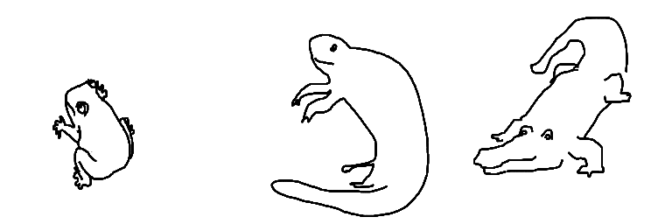


	Input Image
	Class: seagull


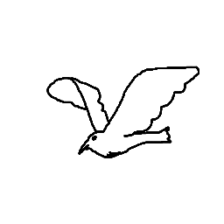


	Positive Image
	Class: seagull


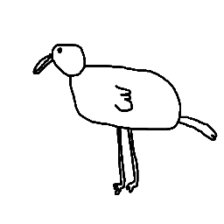


					Predicted Images
					   Grad CAM



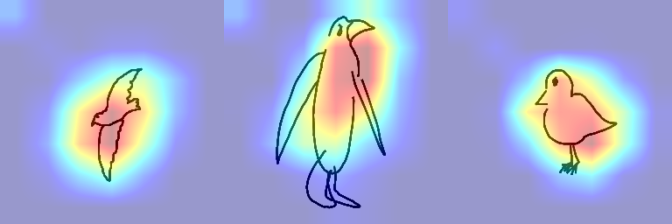

	cos_sim:0.997 			cos_sim:0.976 			cos_sim:0.971
	pred_class: seagull 		pred_class: penguin 		pred_class: songbird


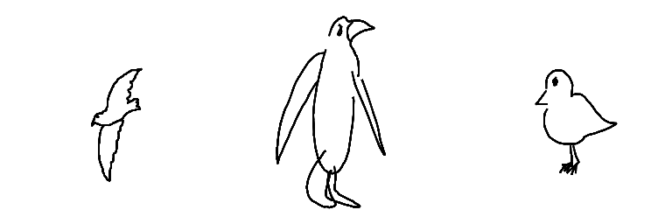


	Input Image
	Class: crocodilian


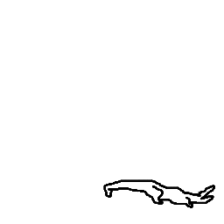


	Positive Image
	Class: crocodilian


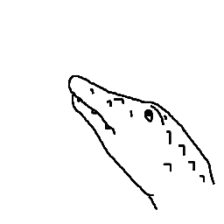


					Predicted Images
					   Grad CAM



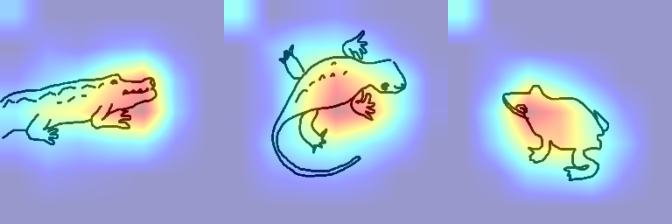

	cos_sim:0.977 			cos_sim:0.952 			cos_sim:0.764
	pred_class: crocodilian 		pred_class: lizard 		pred_class: frog


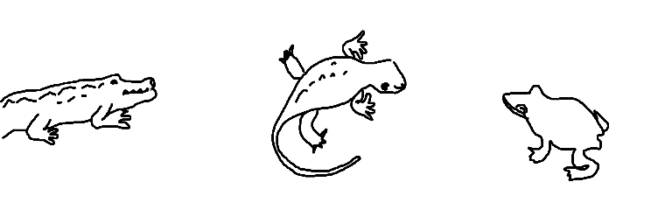


	Input Image
	Class: flower


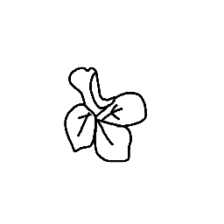


	Positive Image
	Class: flower


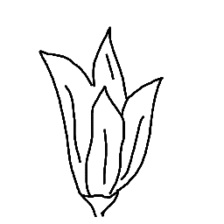


					Predicted Images
					   Grad CAM



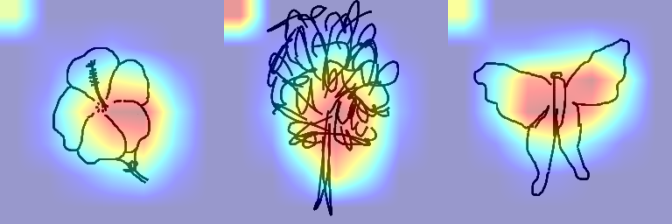

	cos_sim:0.959 			cos_sim:0.784 			cos_sim:0.770
	pred_class: flower 		pred_class: tree 		pred_class: butterfly


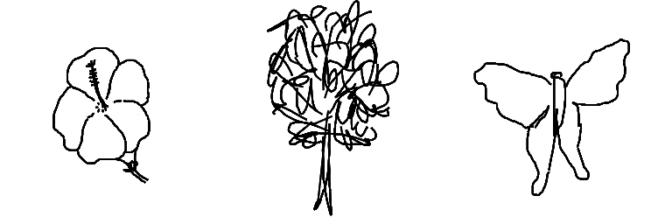


	Input Image
	Class: bread


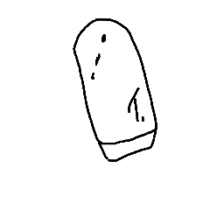


	Positive Image
	Class: bread


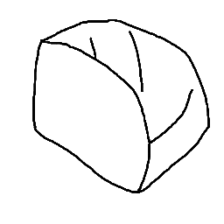


					Predicted Images
					   Grad CAM



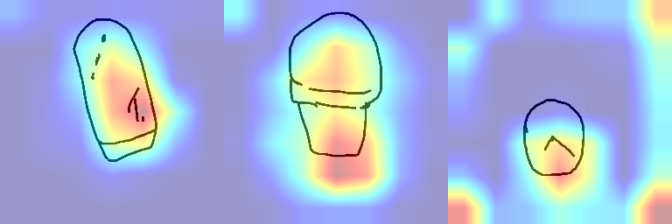

	cos_sim:1.000 			cos_sim:0.896 			cos_sim:0.843
	pred_class: bread 		pred_class: hat 		pred_class: alarm_clock


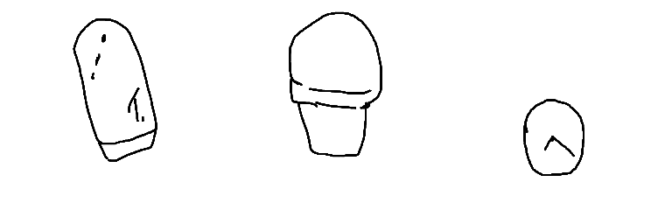


	Input Image
	Class: hourglass


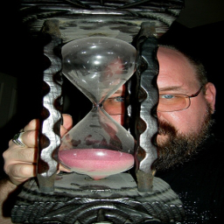


	Positive Image
	Class: hourglass


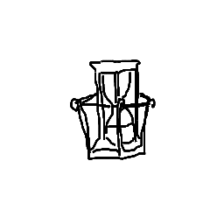


					Predicted Images
					   Grad CAM



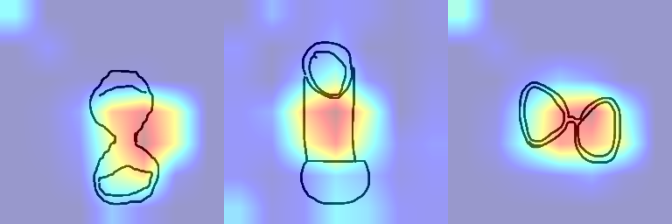

	cos_sim:0.990 			cos_sim:0.518 			cos_sim:0.513
	pred_class: hourglass 		pred_class: alarm_clock 		pred_class: eyeglasses


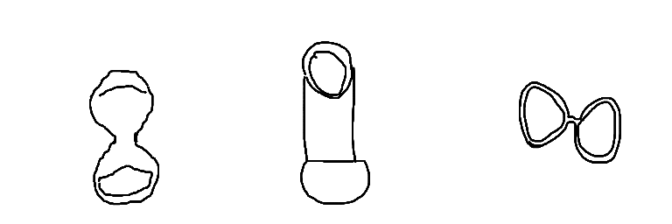


	Input Image
	Class: pear


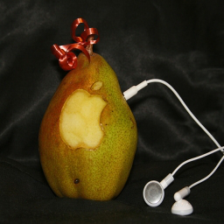


	Positive Image
	Class: pear


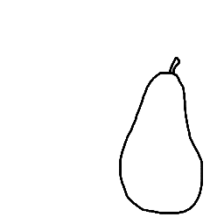


					Predicted Images
					   Grad CAM



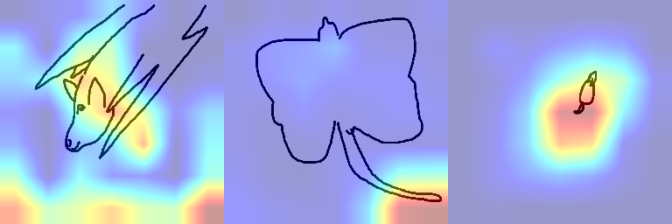

	cos_sim:0.824 			cos_sim:0.778 			cos_sim:0.764
	pred_class: bat 		pred_class: ray 		pred_class: mouse


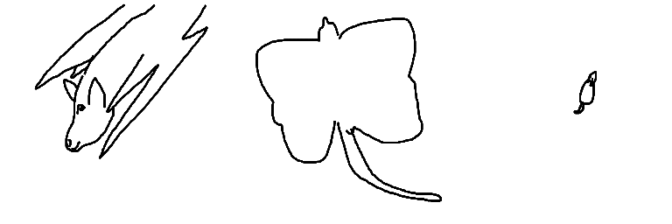


	Input Image
	Class: seal


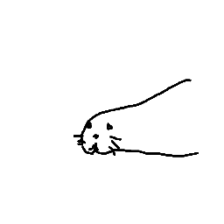


	Positive Image
	Class: seal


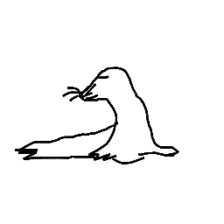


					Predicted Images
					   Grad CAM



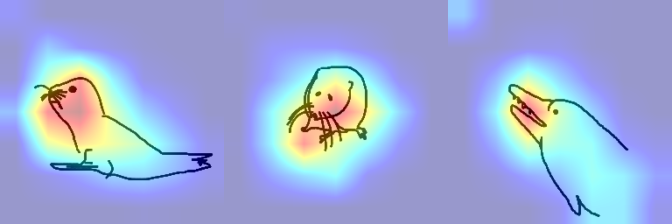

	cos_sim:0.983 			cos_sim:0.869 			cos_sim:0.859
	pred_class: seal 		pred_class: mouse 		pred_class: dolphin


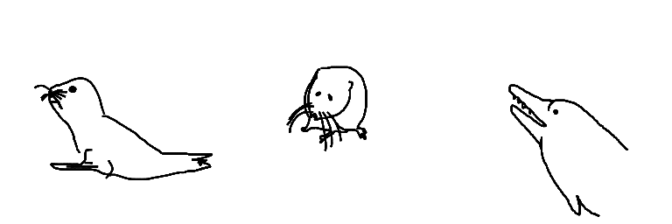


	Input Image
	Class: camel


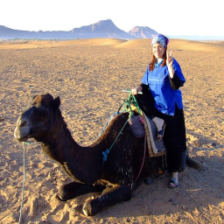


	Positive Image
	Class: camel


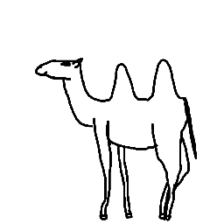


					Predicted Images
					   Grad CAM



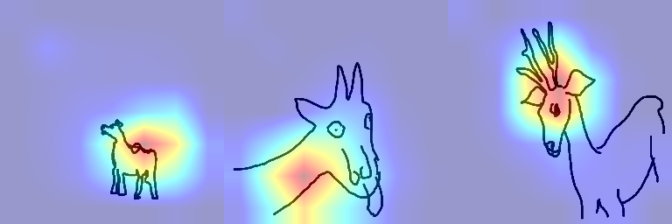

	cos_sim:0.976 			cos_sim:0.865 			cos_sim:0.790
	pred_class: camel 		pred_class: giraffe 		pred_class: deer


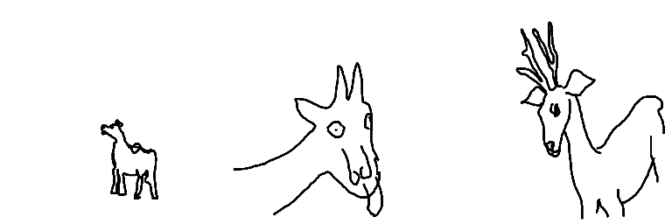


	Input Image
	Class: piano


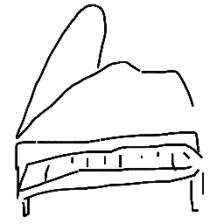


	Positive Image
	Class: piano


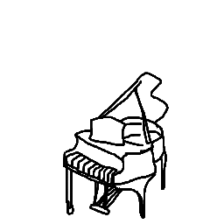


					Predicted Images
					   Grad CAM



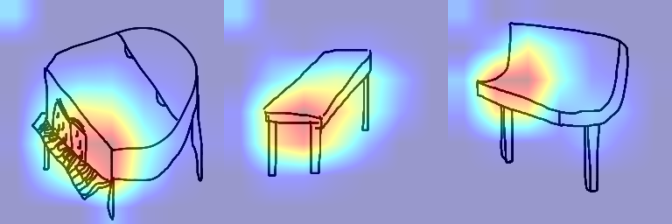

	cos_sim:0.996 			cos_sim:0.904 			cos_sim:0.890
	pred_class: piano 		pred_class: table 		pred_class: bench


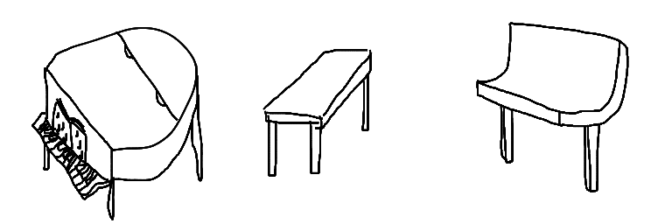


	Input Image
	Class: zebra


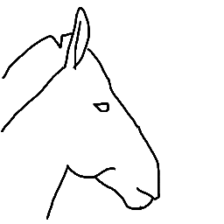


	Positive Image
	Class: zebra


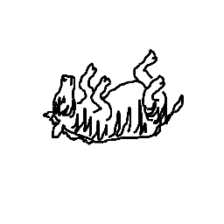


					Predicted Images
					   Grad CAM



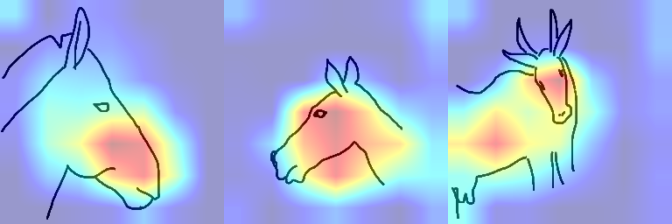

	cos_sim:1.000 			cos_sim:0.967 			cos_sim:0.940
	pred_class: zebra 		pred_class: horse 		pred_class: cow


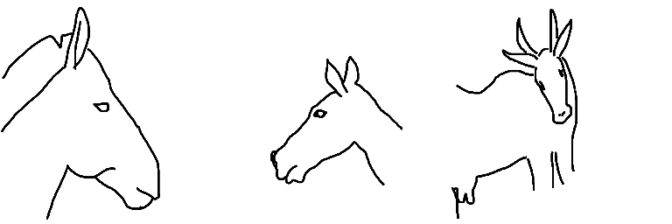


	Input Image
	Class: chicken


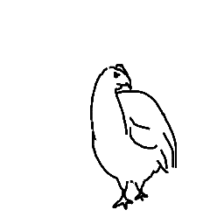


	Positive Image
	Class: chicken


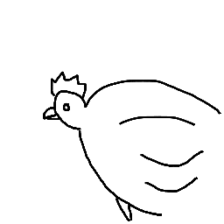


					Predicted Images
					   Grad CAM



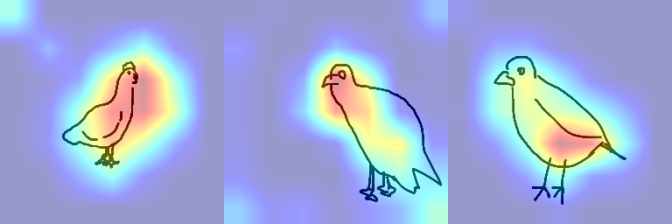

	cos_sim:0.990 			cos_sim:0.985 			cos_sim:0.975
	pred_class: chicken 		pred_class: seagull 		pred_class: songbird


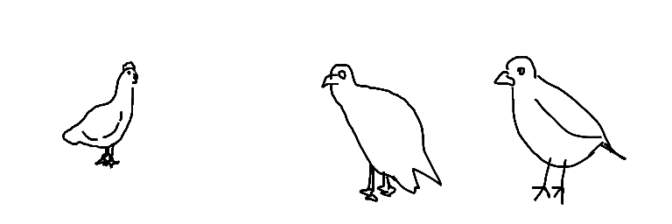


	Input Image
	Class: hammer


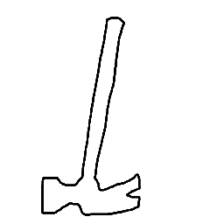


	Positive Image
	Class: hammer


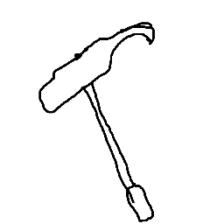


					Predicted Images
					   Grad CAM



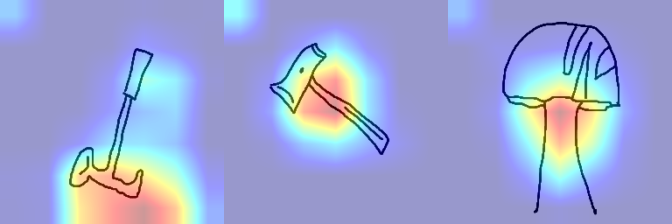

	cos_sim:0.981 			cos_sim:0.960 			cos_sim:0.779
	pred_class: hammer 		pred_class: axe 		pred_class: mushroom


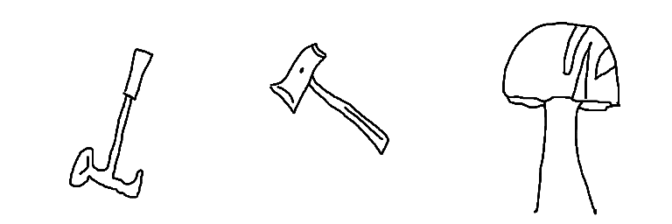


	Input Image
	Class: horse


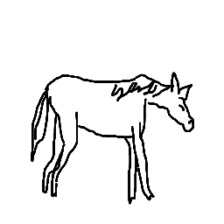


	Positive Image
	Class: horse


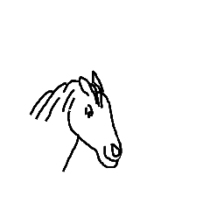


					Predicted Images
					   Grad CAM



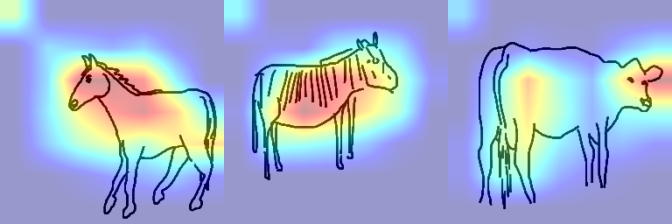

	cos_sim:0.993 			cos_sim:0.961 			cos_sim:0.937
	pred_class: horse 		pred_class: zebra 		pred_class: cow


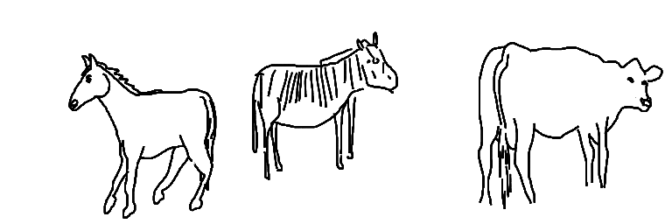


	Input Image
	Class: blimp


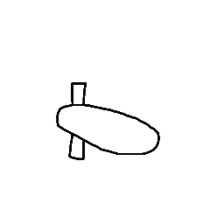


	Positive Image
	Class: blimp


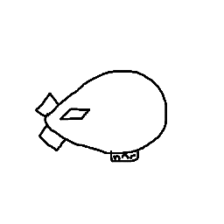


					Predicted Images
					   Grad CAM



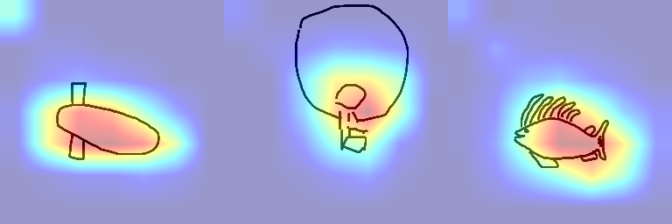

	cos_sim:1.000 			cos_sim:0.783 			cos_sim:0.711
	pred_class: blimp 		pred_class: hot-air_balloon 		pred_class: fish


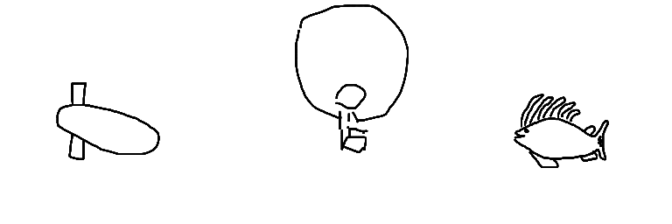


	Input Image
	Class: lobster


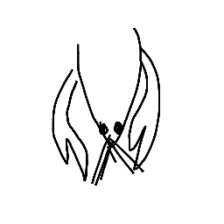


	Positive Image
	Class: lobster


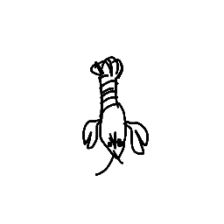


					Predicted Images
					   Grad CAM



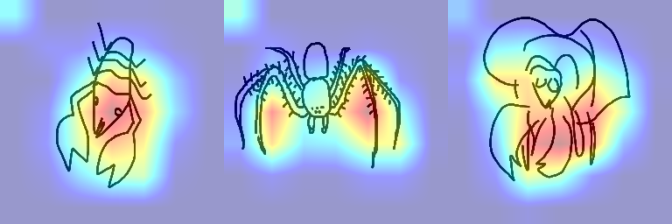

	cos_sim:0.957 			cos_sim:0.925 			cos_sim:0.920
	pred_class: lobster 		pred_class: spider 		pred_class: hermit_crab


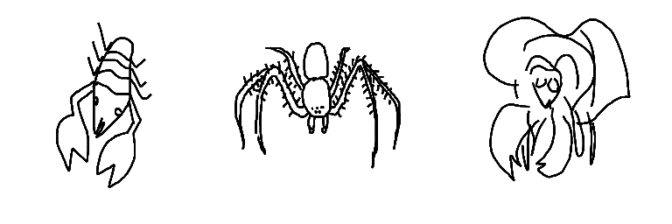


	Input Image
	Class: jellyfish


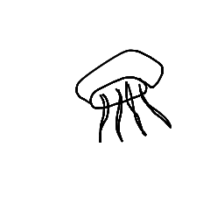


	Positive Image
	Class: jellyfish


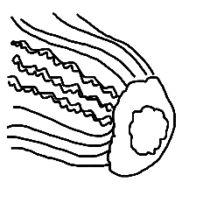


					Predicted Images
					   Grad CAM



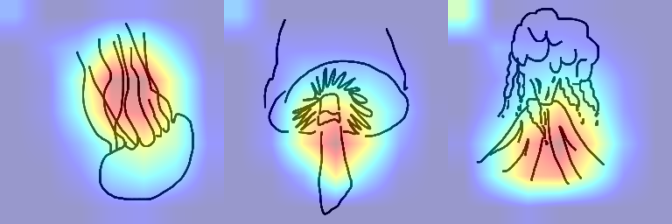

	cos_sim:0.994 			cos_sim:0.717 			cos_sim:0.716
	pred_class: jellyfish 		pred_class: mushroom 		pred_class: volcano


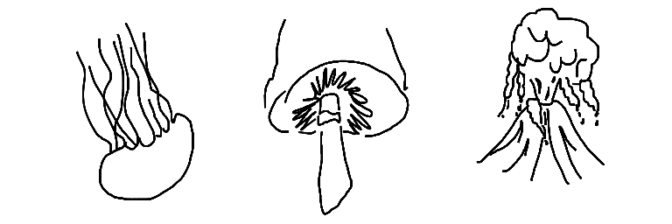


	Input Image
	Class: apple


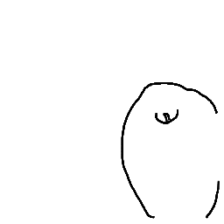


	Positive Image
	Class: apple


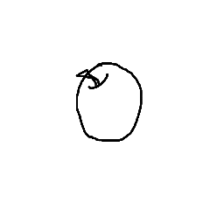


					Predicted Images
					   Grad CAM



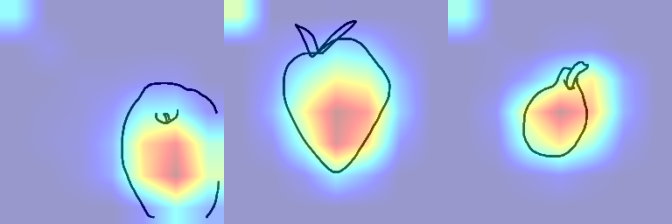

	cos_sim:1.000 			cos_sim:0.917 			cos_sim:0.857
	pred_class: apple 		pred_class: strawberry 		pred_class: pear


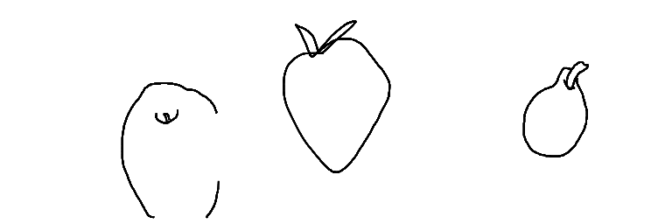


	Input Image
	Class: giraffe


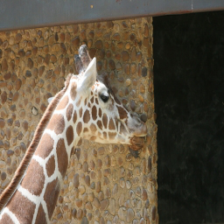


	Positive Image
	Class: giraffe


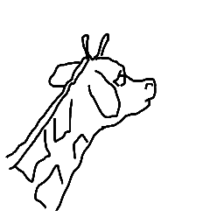


					Predicted Images
					   Grad CAM



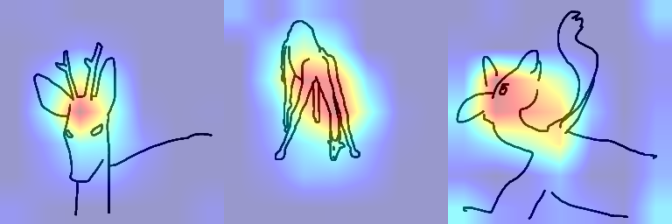

	cos_sim:0.867 			cos_sim:0.860 			cos_sim:0.852
	pred_class: deer 		pred_class: giraffe 		pred_class: kangaroo


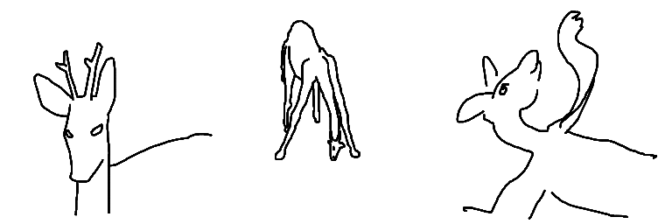


	Input Image
	Class: bear


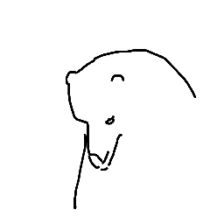


	Positive Image
	Class: bear


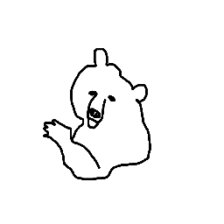


					Predicted Images
					   Grad CAM



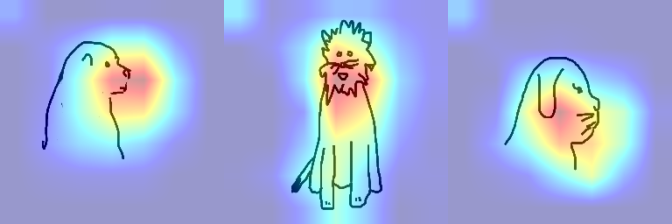

	cos_sim:0.993 			cos_sim:0.965 			cos_sim:0.957
	pred_class: bear 		pred_class: lion 		pred_class: dog


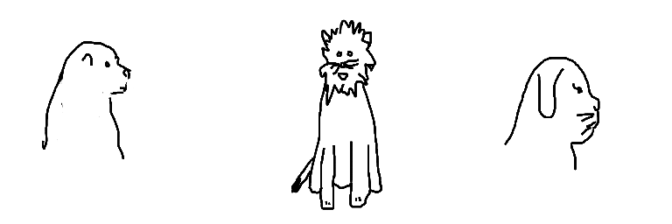


	Input Image
	Class: raccoon


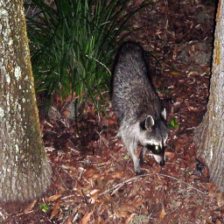


	Positive Image
	Class: raccoon


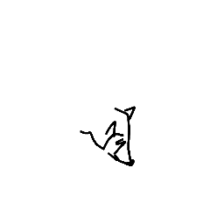


					Predicted Images
					   Grad CAM



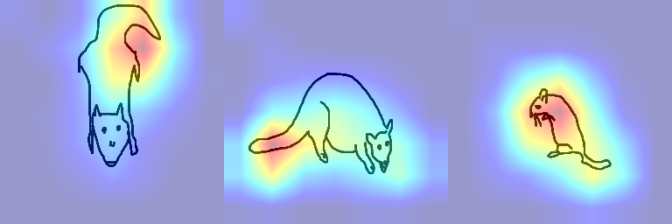

	cos_sim:0.964 			cos_sim:0.950 			cos_sim:0.949
	pred_class: squirrel 		pred_class: raccoon 		pred_class: mouse


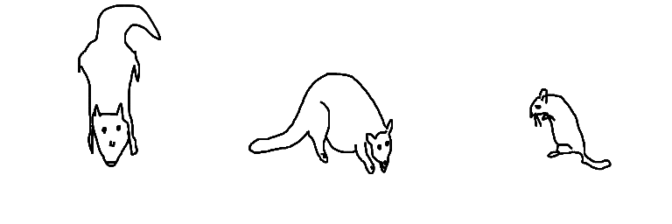


	Input Image
	Class: horse


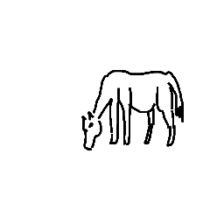


	Positive Image
	Class: horse


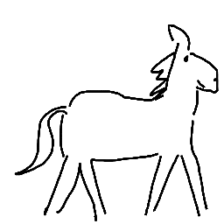


					Predicted Images
					   Grad CAM



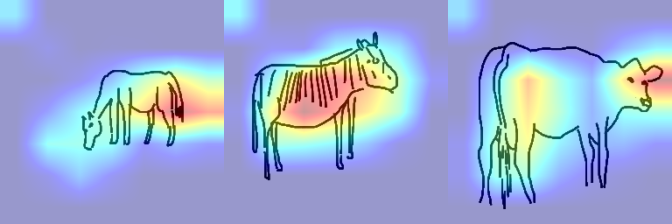

	cos_sim:1.000 			cos_sim:0.970 			cos_sim:0.956
	pred_class: horse 		pred_class: zebra 		pred_class: cow


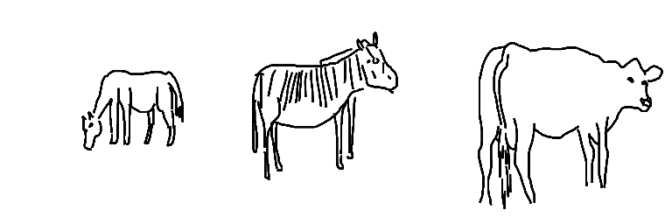


	Input Image
	Class: car_(sedan)


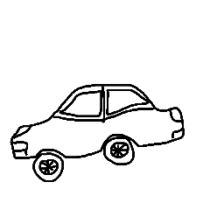


	Positive Image
	Class: car_(sedan)


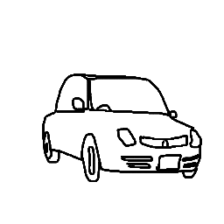


					Predicted Images
					   Grad CAM



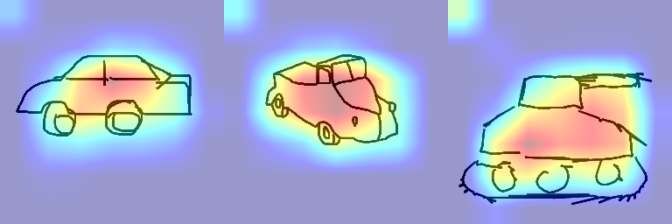

	cos_sim:0.997 			cos_sim:0.956 			cos_sim:0.933
	pred_class: car_(sedan) 		pred_class: pickup_truck 		pred_class: tank


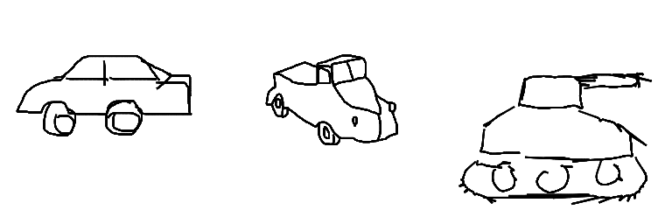


	Input Image
	Class: pretzel


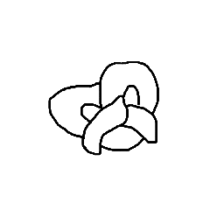


	Positive Image
	Class: pretzel


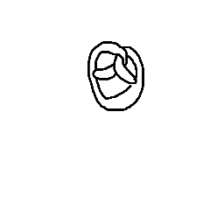


					Predicted Images
					   Grad CAM



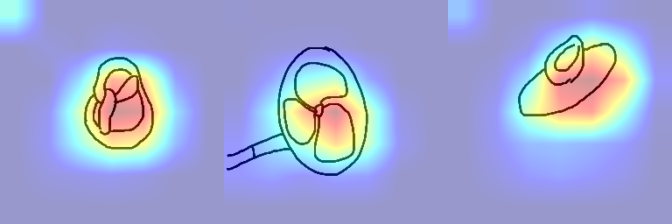

	cos_sim:0.968 			cos_sim:0.690 			cos_sim:0.674
	pred_class: pretzel 		pred_class: fan 		pred_class: hat


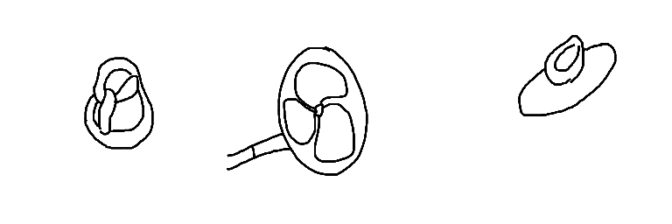


	Input Image
	Class: helicopter


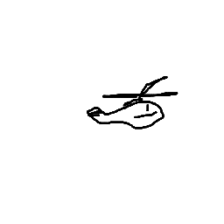


	Positive Image
	Class: helicopter


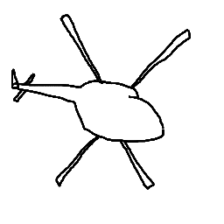


					Predicted Images
					   Grad CAM



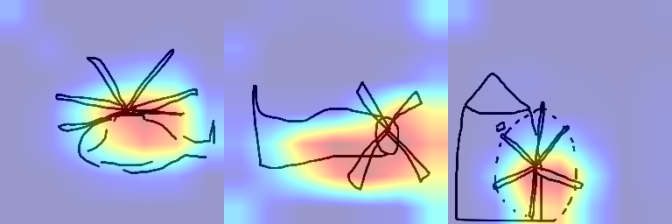

	cos_sim:0.995 			cos_sim:0.805 			cos_sim:0.798
	pred_class: helicopter 		pred_class: airplane 		pred_class: windmill


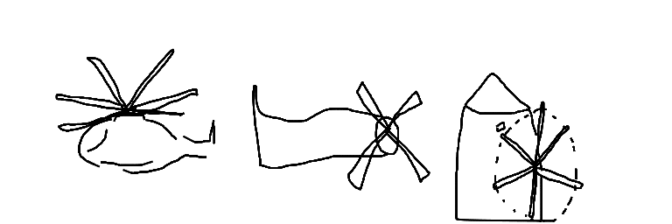


	Input Image
	Class: eyeglasses


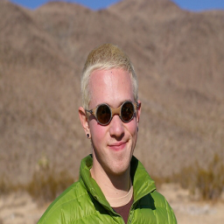


	Positive Image
	Class: eyeglasses


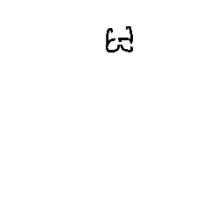


					Predicted Images
					   Grad CAM



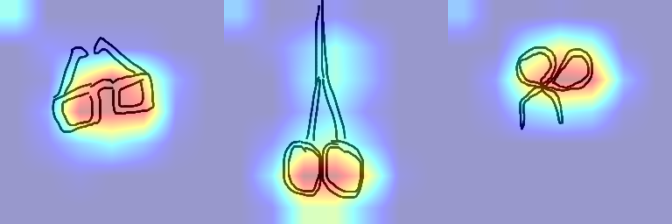

	cos_sim:0.923 			cos_sim:0.765 			cos_sim:0.756
	pred_class: eyeglasses 		pred_class: scissors 		pred_class: pretzel


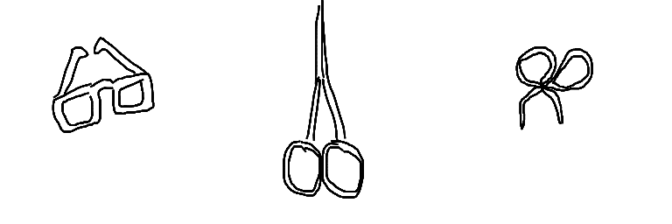


	Input Image
	Class: bicycle


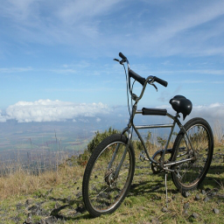


	Positive Image
	Class: bicycle


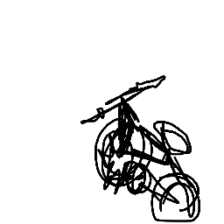


					Predicted Images
					   Grad CAM



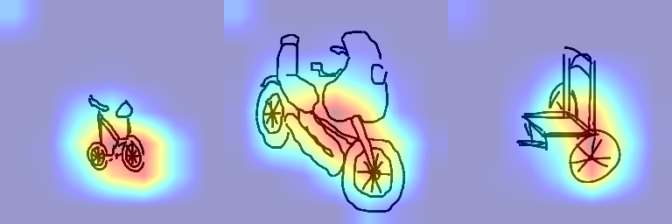

	cos_sim:0.986 			cos_sim:0.952 			cos_sim:0.900
	pred_class: bicycle 		pred_class: motorcycle 		pred_class: wheelchair


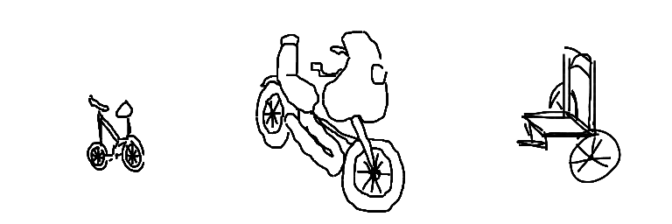


	Input Image
	Class: teddy_bear


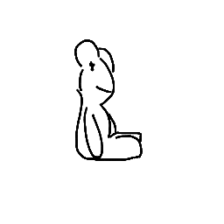


	Positive Image
	Class: teddy_bear


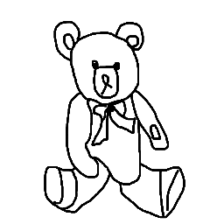


					Predicted Images
					   Grad CAM



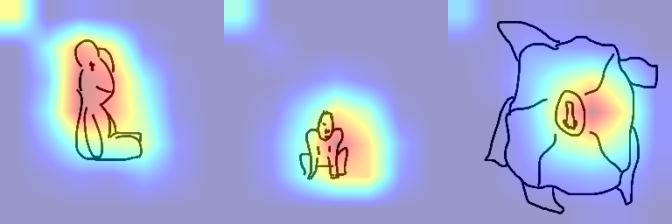

	cos_sim:1.000 			cos_sim:0.685 			cos_sim:0.679
	pred_class: teddy_bear 		pred_class: ape 		pred_class: flower


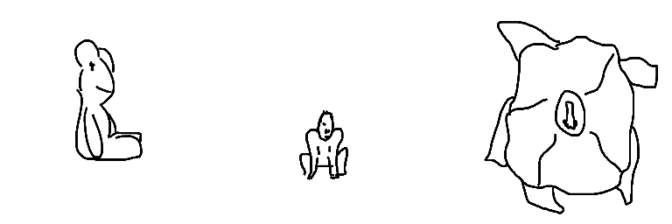


	Input Image
	Class: saw


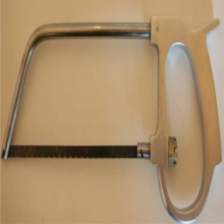


	Positive Image
	Class: saw


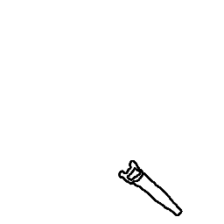


					Predicted Images
					   Grad CAM



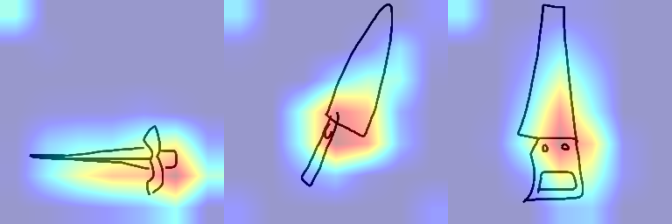

	cos_sim:0.911 			cos_sim:0.909 			cos_sim:0.907
	pred_class: sword 		pred_class: knife 		pred_class: saw


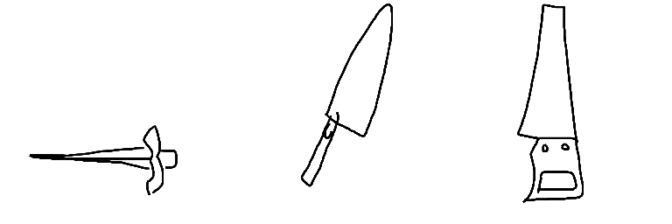


	Input Image
	Class: apple


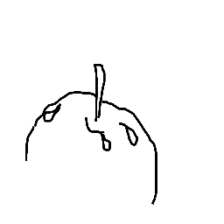


	Positive Image
	Class: apple


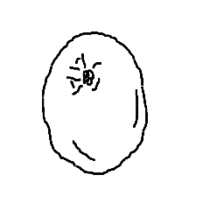


					Predicted Images
					   Grad CAM



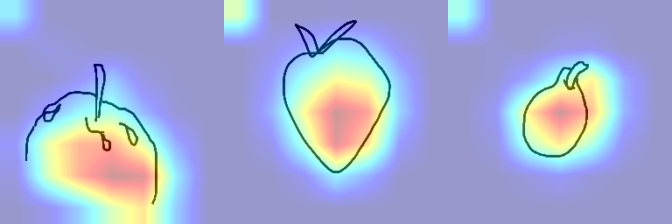

	cos_sim:1.000 			cos_sim:0.919 			cos_sim:0.828
	pred_class: apple 		pred_class: strawberry 		pred_class: pear


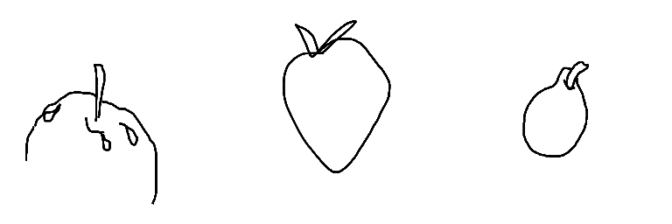

In [4]:
cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
fms_ims_all = results['fms_ims_all']
fms_poss_all = results['fms_poss_all']
fms_negs_all = results['fms_negs_all']
ims = results['ims']
all_classes = results['classes_all']
poss = results['poss']
negs = results['negs']
indices_all = results["topk_inds"]
values_all = results["top_vals"]
classes_all = results["top_r_list"]

cnt = 0
    
for i, im in enumerate(ims):
    if i == 40:
        break
    print('\n\tInput Image')
    print(f"\tClass: {idx_to_clss[all_classes[i].item()]}")
    display(Image.fromarray((ims[i]*255).cpu().numpy().transpose([1,2,0]).astype(np.uint8)))
    print('\n\tPositive Image')
    print(f"\tClass: {idx_to_clss[all_classes[i].item()]}")
    display(Image.fromarray((poss[i]*255).cpu().numpy().transpose([1,2,0]).astype(np.uint8)))
    cnt += 1

    img_list = []
    img_list_gt = []
    pil_visualization = []
    for j in indices_all[i][:15]:
        img = (poss[j]*255).cpu().numpy().transpose([1,2,0]).astype(np.uint8)
        img_list.append(img)
        oris = poss[j]
        ori_cam = ((oris)*255).cpu().numpy().transpose([1,2,0]).astype(np.uint8) / 255
        cam = GradCAM(model=m, target_layers=[m.conv_head], use_cuda=True)
        grayscale_cam = cam(input_tensor=oris.unsqueeze(0))
        grayscale_cam = grayscale_cam[0, :]
        visualization = show_cam_on_image(ori_cam, grayscale_cam, image_weight=0.6, use_rgb = True)
        pil_visualization.append(visualization)
    print('\n\t\t\t\t\tPredicted Images')
    print('\t\t\t\t\t   Grad CAM\n')
    display(Image.fromarray(cv2.hconcat(pil_visualization)))
        
    if len(values_all[i]) < 3:
        pass
    else:
        print(f'\tcos_sim:{values_all[i][0]:.3f} \t\t\tcos_sim:{values_all[i][1]:.3f} \t\t\tcos_sim:{values_all[i][2]:.3f}')
        print(f'\tpred_class: {idx_to_clss[classes_all[i][0]]} \t\tpred_class: {idx_to_clss[classes_all[i][1]]} \t\tpred_class: {idx_to_clss[classes_all[i][2]]}')
    display(Image.fromarray(np.concatenate(img_list, axis=1)))